In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import itertools
from collections import defaultdict
import io
import gurobipy as gp
from gurobipy import GRB
from itertools import combinations
from random import sample
import math
import json
import random
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ['Computer Modern Roman'],
})

In [2]:
def gen_sols(n,m,quer_dict,noise,n_sols):
    """ builds ILP to construct candidate database, based on answers to queries 
    Assumes bound on noise, n and m is known. """
    M = gp.Model()
    M.Params.OutputFlag = 0
    
    y_var_dict = defaultdict()
    y_p_var_dict = defaultdict()
    y_n_var_dict = defaultdict()

    # Initialize the decision variables
    x = np.array([[M.addVar(vtype='B', name=f"x_{i}_{j}") 
                   for j in range(m)] for i in range(n)])
    # print(x)
    
    for quer in quer_dict.keys():
        y_var_dict[quer] = []
        y_p_var_dict[quer] = []
        y_n_var_dict[quer] = []
        
        positions_0 = []
        positions_1 = []
        for i, j in zip(quer[0],quer[1]):
            if j == 0: 
                positions_0.append(i)
            elif j ==1:
                positions_1.append(i)
        for i in range(n):
            y_var_dict[quer].append(M.addVar(vtype='B', name=f"y_{quer}_{i}"))
            y_p_var_dict[quer].append(M.addVar(vtype='B', name=f"y_p_{quer}_{i}"))
            y_n_var_dict[quer].append(M.addVar(vtype='B', name=f"y_n_{quer}_{i}"))
            
            M.addConstr( len(quer[0])*y_var_dict[quer][i] + (len(quer[0])+0.5)*y_p_var_dict[quer][i] <= 
                        sum([x[i][j] for j in positions_1]) + sum([(1-x[i][j]) for j in positions_0]))
            M.addConstr( (len(quer[0])-0.5)*y_n_var_dict[quer][i] + len(quer[0])*y_var_dict[quer][i] + m*y_p_var_dict[quer][i] >= 
                        sum([x[i][j] for j in positions_1])+ sum([(1-x[i][j]) for j in positions_0]))
            M.addConstr( y_var_dict[quer][i] + y_p_var_dict[quer][i] + y_n_var_dict[quer][i] == 1)
            
        if noise == 0:
            M.addConstr(sum(y_var_dict[quer]) == quer_dict[quer])
        else:
            M.addConstr(sum(y_var_dict[quer]) <= quer_dict[quer] + noise)
            M.addConstr(sum(y_var_dict[quer]) >= quer_dict[quer] - noise)
            
    # for i in range(n-1):
    #     M.addConstr(binatodeci(x[i]) <= binatodeci(x[i+1]))
    bin_cons(M,x,n)

    # Parameters
    M.Params.PoolSearchMode = 2
    M.Params.PoolSolutions = n_sols
    # m.Params.PoolSolutions = 2
    M.Params.PoolGap = 0.0

    # Optimize
    M.optimize()
    
    # print(f"Took {M.Runtime:.2f} seconds to solve")
    
    out_lst = []
    for k in range(M.SolCount):
        M.Params.SolutionNumber = k
        out_x = np.zeros_like(x)
        for i in range(len(x)):
            for j in range(len(x[0])):
                out_x[i][j] = x[i][j].Xn
        # print([var.Xn for var in m.getVars()])
        out_lst.append(out_x)
        
    return out_lst, M.Runtime

In [3]:
def bin_cons(M,x,n):
    """ Adds binary symmetry breaking constraint """
    for i in range(n-1):
        M.addConstr(binatodeci(x[i]) <= binatodeci(x[i+1]))
    return None

In [2]:
def gen_bin_data_set(n,m):
    """n is number of people, m is number of attributes used, database is uniform random"""
    db = pd.DataFrame(np.random.randint(0,2,size=(n, m)), columns=[f'att_{x}' for x in range(m)])
    return db

In [34]:
def gen_partial_info(db,n_partials,m_partials):
    n = db.shape[0]
    m = db.shape[1]
    row_inds = np.random.choice(n,n_partials, replace = False)
    partial_dict = defaultdict(lambda:0)

    for i in row_inds:
        att_sample = np.random.choice(m,m_partials, replace = False)
        lst = []
        for j in att_sample:
            lst.append(int(db[i:i+1][f"att_{j}"]))
        # print(lst)
        print((tuple(att_sample),tuple(lst)))
        partial_dict[(tuple(att_sample),tuple(lst))] += 1
    return partial_dict

aa = gen_bin_data_set(5,3)
print(aa)
print(gen_partial_info(aa,2,2))

   att_0  att_1  att_2
0      0      0      0
1      0      0      0
2      1      1      1
3      1      1      0
4      0      0      0
((0, 2), (1, 0))
((1, 2), (0, 0))
defaultdict(<function gen_partial_info.<locals>.<lambda> at 0x14e7d90d0>, {((0, 2), (1, 0)): 1, ((1, 2), (0, 0)): 1})


In [5]:
def gen_powerset(k):
    """ generates a powerset of k elements """
    out = []
    for i in itertools.product([0,1],repeat=k):
        out.append(i)
    return out

In [6]:
def gen_queries_uniform_complete(m,n_queries):
    """Generates all possible queries of m binary attributes, 
    takes a sample of size n_queries from the set"""
        
    queries = []
    for i in range(1,m+1):
        
        combs = itertools.combinations(range(m),i)
        for comb in combs:
            for choice in gen_powerset(i):
                quer = []
                quer.append(comb)
                quer.append(choice)
                queries.append(tuple(quer))
                
    return sample(queries,min(n_queries,len(queries)))

In [7]:
def gen_queries_uniform(m,n_queries):
    """Generates random queries. Chooses number of attributes uniformly over [1,m],
    Would be interested to see how this changes with a skewed distribution, also
    would be interesting how it changes if symmetry in queries is forced"""
    
    queries = []

    for i in range(n_queries):
        quer = []
        atts = np.random.randint(1,m+1)
        quer.append(tuple(sorted(sample(range(m),atts))))
        quer.append(tuple(np.random.choice([0,1], size=[atts])))
        queries.append(quer)

    queries = list(set([tuple(x) for x in queries]))

    return queries

In [8]:
def quer2string(query):
    """ converts query to a string to be used by pandas 'query' function"""
    string = ""
    for pos, att in enumerate(query[0]):
        string += f'att_{att} == {query[1][pos]} & '
    return string[0:-3]

In [9]:
def get_counts(db,quers,noise):
    """Returns noisy count of query, noise is uniform random integer over -noise to noise (inclusive). 
    Will perturb negative counts to 0."""
    out_dict = defaultdict(int)
    for query in quers:
        out_dict[tuple(query)] = max(len(db.query(quer2string(query))) + np.random.randint(-noise,noise+1),0)
    return out_dict

In [10]:
def binatodeci(binary):
    return sum(val*(2**idx) for idx, val in enumerate(reversed(binary)))

In [11]:
def check_fixed_sols(sols):
    """Takes some candidate databases and returns which
    rows are contained in all of them, including duplicates"""
    
    if len(sols) == 1:
        return list(sols[0])
    
    out_lst = []
    for sol in sols:
        temp = []
        for row in sol:
            temp.append(tuple(row))
        out_lst.append(temp)
    # print(out_lst)

    fixed_sols = []
    for row in out_lst[0]:
        count = 0
        for sol in out_lst[1:]:
            if row in sol:
                sol.remove(row)
                count += 1
            # else:
            #     break
        if count == len(sols) - 1:
            fixed_sols.append(row)
    return fixed_sols

In [12]:
print(check_fixed_sols([[(0,0),(1,0),(1,0)],[(1,0),(0,0),(0,0)],[(0,0),(1,0),(0,0)]]))

[(0, 0), (1, 0)]


In [13]:
def total_sim(sol,db):
    count = 0
    for i, val_i in enumerate(db):
        for j, val_j in enumerate(val_i):
            # print(val_j, sol[i][j])
            if val_j != sol[i][j]:
                count += 1
            
    return  1 - count/(len(db[0])*len(db))

In [14]:
# def find_closest(row,db):
#     current_dist = 0
#     for row_comp in db:
#         dist = sum([abs(row_comp[j]-row[j]) for j in range(len(row))])
#         if dist >= current

# def total_sim(sol,db):
#     tot_count = 0
    
#     for row in db:
        
#     for i, val_i in enumerate(db):
#         for j, val_j in enumerate(val_i):
#             # print(val_j, sol[i][j])
#             if val_j != sol[i][j]:
#                 count += 1
            
#     return  1 - count/(len(db[0])*len(db))

In [15]:
def gen_cij(db,sol,i,j):
    """ computes cost of assigning row i of solution 
    to row j of database in terms of L1 norm"""
    
    cost = sum([abs(db[j][k]-sol[i][k]) for k in range(len(sol[0]))])
    return cost

def ass_ILP(db,sol):
    """ Creates an optimal assignment of rows in the solution 
    to the rows in the true database, the objective function value
    is returned and is the smallest number of differences between
    solution and true database, based on row swapping"""
    n = len(sol)
    
    # c_ij = []
    # for i in range(n):
    #     temp = []
    #     for j in range(n):
    #         temp.append(gen_cij(db,sol,i,j))
    #     c_ij.append(temp)
    # print(np.array(c_ij))  
    
    M = gp.Model()
    M.Params.OutputFlag = 0
    
    x = np.array([[M.addVar(vtype='B', name=f"x_{i}_{j}") 
               for j in range(n)] for i in range(n)])
    
    for i in range(n):
        M.addConstr(sum(x[i,:]) == 1)
        M.addConstr(sum(x[:,i]) == 1)
        
    # M.setObjective(sum([sum([x[i][j]*c_ij[i][j] for j in range(n)]) for i in range(n)]), GRB.MINIMIZE)
    M.setObjective(sum([sum([x[i][j]*gen_cij(db,sol,i,j) for j in range(n)]) for i in range(n)]), GRB.MINIMIZE)
    
    M.optimize()
    
    out_x = np.zeros_like(x)
    for i in range(len(x)):
        for j in range(len(x[0])):
            out_x[i][j] = x[i][j].Xn
    print(out_x)
    
    return 1 - M.ObjVal/(len(db)*len(db[0]))

In [643]:
n = 30
m = 5

sims = []
sims_row = []
for i in range(1000):
    db1 = gen_bin_data_set(n,m)
    db1 = sorted([tuple(x) for x in list(db1.to_numpy())],key=binatodeci)
    db2 = gen_bin_data_set(n,m)
    db2 = sorted([tuple(x) for x in list(db2.to_numpy())],key=binatodeci)
    sims.append(ass_ILP(db1,db2))
    db2, common = db2[:], [ e for e in db1 if e in db2 and (db2.pop(db2.index(e)) or True)]
    sims_row.append(len(common)/n)
print(np.mean(sims), np.mean(sims_row))

0.8539666666666667 0.4702


In [41]:
n = 30
m = 5
n_queries = 300
noise = 0
# counts = defaultdict(lambda:0)
counts = []
for i in range(500):
    db = gen_bin_data_set(n,m)
    quers = gen_queries_uniform_complete(m,n_queries)
    quer_dict = get_counts(db,quers,noise)
    for val in quer_dict.values():
        counts.append(val)

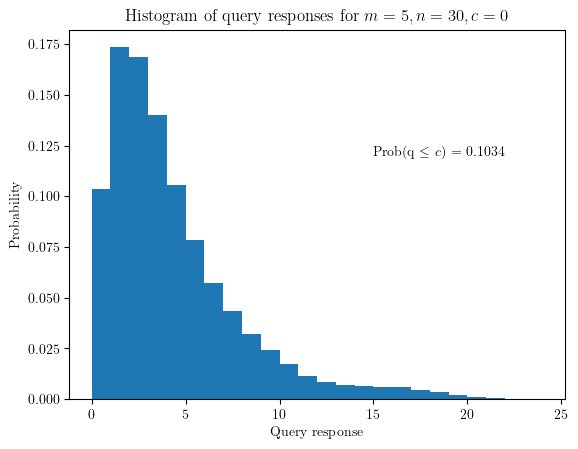

In [42]:
c = 0
plt.hist(counts, density=True, bins=max(counts))  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Query response')
low_count = 0
high_count = 0
for count in counts:
    if count <= c:
        low_count += 1
    else:
        high_count += 1
plt.text(15,0.12,s = f'Prob(q $\leq$ $c$) = {low_count/(low_count+high_count):.4f}')

plt.title(f'Histogram of query responses for $m=5, n=30,c={c}$')
# plt.title(f"$c$")
# plt.ylim([0,105])
# plt.legend()
plt.savefig(f'N_q_n_30_n_5_c_0_1_2_3/histogram_m_5_n_30_c_{c}.pdf') 
plt.show()

In [18]:
low_count = 0
high_count = 0
for count in counts:
    if count <= 3:
        low_count += 1
    else:
        high_count += 1
print(low_count/(low_count+high_count))

0.5280330578512397


In [676]:
n = 30
m = 5
n_queries = 300
n_sols = 10
noise = 1

#generating database
db = gen_bin_data_set(n,m)
# display(db)

#generating queries
quers = gen_queries_uniform_complete(m,n_queries)
print(f"Number of Queries: {len(quers)}")

#generating counts with noise
quer_dict = get_counts(db,quers,noise)
# print(np.mean([x for x in quer_dict.values()]))

db_tup = sorted([tuple(x) for x in list(db.to_numpy())],key=binatodeci)
db_dict = {i:db_tup.count(i) for i in set(db_tup)}

#solving:
sols_all = gen_sols(n,m,quer_dict,noise,n_sols)
sols = np.array(sols_all[0], dtype=int) 
time = sols_all[1]
print(f"Took {time:.2f} seconds to solve")

#generating fixed rows
fixed_sols = check_fixed_sols(sols)
print(f"Found {len(sols)} solution(s)")
print(f"{len(fixed_sols)} out of {n} rows are 'fixed'")

for sol in sols:
    
    # dont think this section works perfectly -- cant handle duplicate individuals?
    sol_tup = [tuple(x) for x in sol]
    sol_tup, common = sol_tup[:], [ e for e in db_tup if e in sol_tup and (sol_tup.pop(sol_tup.index(e)) or True)]
    # print(sol_tup)
    # print(db_tup)
    # print(common)
    print(f"Total sim: {ass_ILP(db_tup,sol_tup):.4f}")
    print(f"Row sim: {len(common)/len(sol_tup):.4f}")
    # print(f"Total similarity is {total_sim(sol_tup,db_tup):.2f}")
    # sol_dict = {i:sol_tup.count(i) for i in set(sol_tup)}

Number of Queries: 242
3.9132231404958677
Took 0.80 seconds to solve
Found 1 solution(s)
30 out of 30 rows are 'fixed'
Total sim: 1.0000
Row sim: 1.0000


In [19]:
def get_results(c,n,m,N_q,N_sols):

    noise = c
    db = gen_bin_data_set(n,m)
    quers = gen_queries_uniform_complete(m,N_q)
    quer_dict = get_counts(db,quers,noise)

    db_tup = sorted([tuple(x) for x in list(db.to_numpy())],key=binatodeci)

    #solving:
    sols_all = gen_sols(n,m,quer_dict,noise,N_sols)
    sols = np.array(sols_all[0], dtype=int) 
    time = sols_all[1] 
    
    backbone_size = 0
    if len(sols) < N_sols:
        fixed_sols = check_fixed_sols(sols)
        backbone_size = len(fixed_sols)/n
    
    row_sims = []
    tot_sims = []
    
    for sol in sols:
        sol_tup = [tuple(x) for x in sol]
        sol_tup, common = sol_tup[:], [ e for e in db_tup if e in sol_tup and (sol_tup.pop(sol_tup.index(e)) or True)]
        tot_sims.append(ass_ILP(db_tup,sol_tup))
        row_sims.append(len(common)/n)
    
    returns = {'backbone_size': backbone_size, 'tot_avg': np.mean(tot_sims), 'tot_min': np.min(tot_sims),
              'row_avg': np.mean(row_sims), 'row_min': np.min(row_sims), 'solve_time': time, 'N_sols_actual': len(sols)}
    
    return returns

In [655]:
c=3
n=50
m=5
N_q=242
N_sols=1000
print(get_results(c,n,m,N_q,N_sols))

{'backbone_size': 0.92, 'tot_avg': 0.992, 'tot_min': 0.988, 'row_avg': 0.96, 'row_min': 0.94, 'solve_time': 3.3363311290740967, 'N_sols_actual': 3}


In [656]:
def produce_avgs_over_N_q(n,m,c_range,N_q_range,N_trials,N_sols):
    all_results = defaultdict()
    for c in c_range:
        print(c)
        results = defaultdict()
        for N_q in N_q_range[c]:
            print(N_q)
            temp = []
            for trial in range(N_trials):
                temp.append(get_results(c,n,m,N_q,N_sols))
            df = pd.DataFrame(temp)
            results[N_q] = dict(df.mean()) 
        all_results[c] = results
    return all_results

In [611]:
N_q_range = {0: np.linspace(10,242,20, dtype = 'int'),
            1: np.linspace(40,242,20, dtype = 'int'),
            2: np.linspace(100,242,15, dtype = 'int'),
            3: np.linspace(170,242,6, dtype = 'int')}

data = produce_avgs(30,5,[0,1,2,3],N_q_range,30,1000)

0
10
22
34
46
58
71
83
95
107
119
132
144
156
168
180
193
205
217
229
242
1
40
50
61
71
82
93
103
114
125
135
146
156
167
178
188
199
210
220
231
242
2
100
110
120
130
140
150
160
171
181
191
201
211
221
231
242
3
170
184
198
213
227
242


In [663]:
new_dict = defaultdict()
for c in data.keys():
    temp_dict = defaultdict()
    for N_q in data[c].keys():
        temp_dict[int(N_q)] = data[c][N_q]
    new_dict[int(c)] = temp_dict
with open('c_0_1_2_3_Nt_30_n_30_m_5_.json', 'w') as f: 
    json.dump(new_dict, f)

In [582]:
print(np.linspace(100,242,20, dtype = 'int'))

[100 107 114 122 129 137 144 152 159 167 174 182 189 197 204 212 219 227
 234 242]


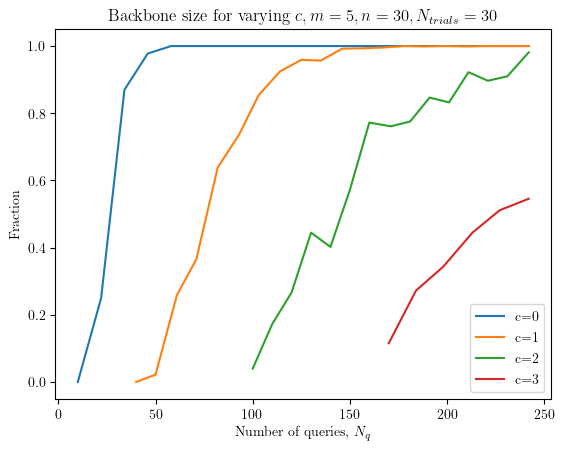

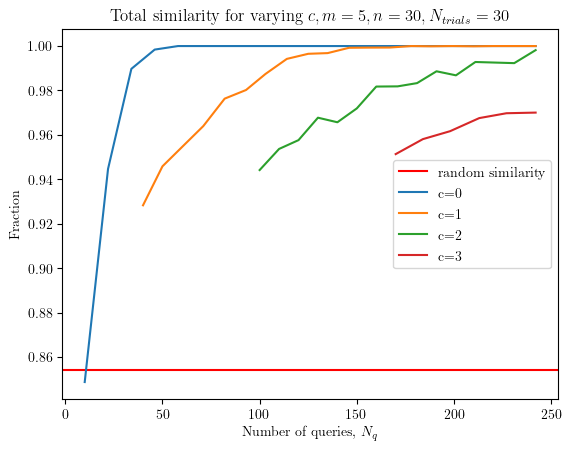

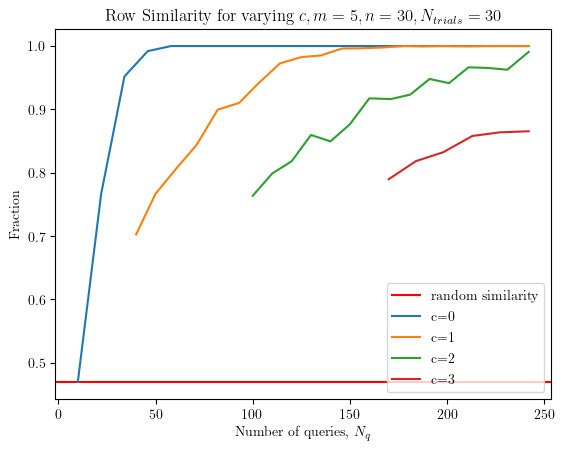

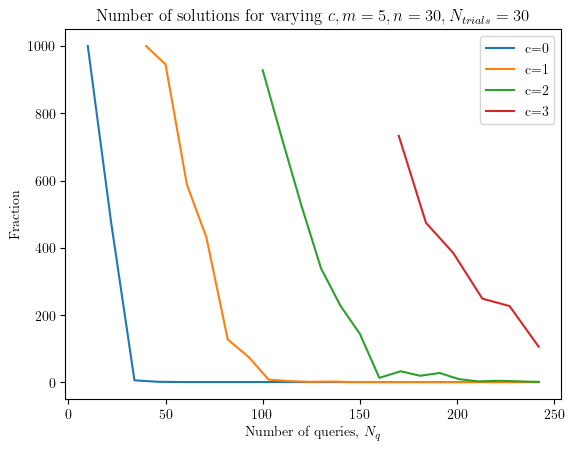

In [647]:
for feature in ['backbone_size', 'tot_avg', 'row_avg', 'N_sols_actual']:    
    heading_dict = {'backbone_size': 'Backbone size', 'tot_avg': 'Total similarity',
                    'row_avg': "Row Similarity", 'N_sols_actual': "Number of solutions"}
    
    x0 = data[0].keys()
    x1 = data[1].keys()
    x2 = data[2].keys()
    x3 = data[3].keys()
    y0 = [data[0][i][feature] for i in x0]
    y1 = [data[1][i][feature] for i in x1]
    y2 = [data[2][i][feature] for i in x2]
    y3 = [data[3][i][feature] for i in x3]
    if feature == 'tot_avg':
        plt.axhline(y = 0.854, color = 'r', linestyle = '-', label = 'random similarity')
    if feature == 'row_avg':
        plt.axhline(y = 0.47, color = 'r', linestyle = '-', label = 'random similarity')
    # x, y = zip(*sorted(zip(x, y)))

    plt.plot(x0, y0, label = 'c=0')
    plt.plot(x1, y1, label = 'c=1')
    # plt.axhline(y1 = 95, color = 'r', linestyle = '-', label = '95\%')
    plt.plot(x2, y2, label = 'c=2')
    plt.plot(x3, y3, label = 'c=3')
    plt.xlabel('Number of queries, $N_q$')
    plt.ylabel('Fraction')
    # plt.xscale('log')
    # plt.yscale('log')
    plt.title(f'{heading_dict[feature]} for varying $c, m=5, n=30, N_{{trials}} =30$')
    # plt.title(f"$c$")
    # plt.ylim([0,105])
    plt.legend()
    plt.savefig(f'more_avgs/{feature}_m_5_n_30_N_t_30.pdf') 
    plt.show()

In [17]:
def produce_avgs_over_n(n_range,m,c_range,N_q,N_trials,N_sols):
    all_results = defaultdict()
    for c in c_range:
        print(c)
        results = defaultdict()
        for n in n_range[c]:
            print(n)
            temp = []
            for trial in range(N_trials):
                temp.append(get_results(c,n,m,N_q,N_sols))
            df = pd.DataFrame(temp)
            results[n] = dict(df.mean()) 
        all_results[c] = results
    return all_results

In [20]:
n_range = {0: np.linspace(10,50,5, dtype = 'int'),
            1: np.linspace(10,50,5, dtype = 'int'),
            2: np.linspace(10,50,5, dtype = 'int'),
            3: np.linspace(10,50,5, dtype = 'int')}

data_n = produce_avgs_over_n(n_range,4,[0,1,2,3],242,10,1000)

0
10
Set parameter Username
Academic license - for non-commercial use only - expires 2023-05-08
20
30
40
50
1
10
20
30
40
50
2
10
20
30
40
50
3
10
20
30
40
50


In [672]:
print(data_n)

defaultdict(None, {0: defaultdict(None, {10: {'backbone_size': 1.0, 'tot_avg': 1.0, 'tot_min': 1.0, 'row_avg': 1.0, 'row_min': 1.0, 'solve_time': 0.05780911445617676, 'N_sols_actual': 1.0}, 20: {'backbone_size': 1.0, 'tot_avg': 1.0, 'tot_min': 1.0, 'row_avg': 1.0, 'row_min': 1.0, 'solve_time': 0.09735584259033203, 'N_sols_actual': 1.0}, 30: {'backbone_size': 1.0, 'tot_avg': 1.0, 'tot_min': 1.0, 'row_avg': 1.0, 'row_min': 1.0, 'solve_time': 0.2843010425567627, 'N_sols_actual': 1.0}, 40: {'backbone_size': 1.0, 'tot_avg': 1.0, 'tot_min': 1.0, 'row_avg': 1.0, 'row_min': 1.0, 'solve_time': 0.5965900421142578, 'N_sols_actual': 1.0}, 50: {'backbone_size': 1.0, 'tot_avg': 1.0, 'tot_min': 1.0, 'row_avg': 1.0, 'row_min': 1.0, 'solve_time': 0.878472089767456, 'N_sols_actual': 1.0}}), 1: defaultdict(None, {10: {'backbone_size': 1.0, 'tot_avg': 1.0, 'tot_min': 1.0, 'row_avg': 1.0, 'row_min': 1.0, 'solve_time': 0.1193239688873291, 'N_sols_actual': 1.0}, 20: {'backbone_size': 1.0, 'tot_avg': 1.0, 'to

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


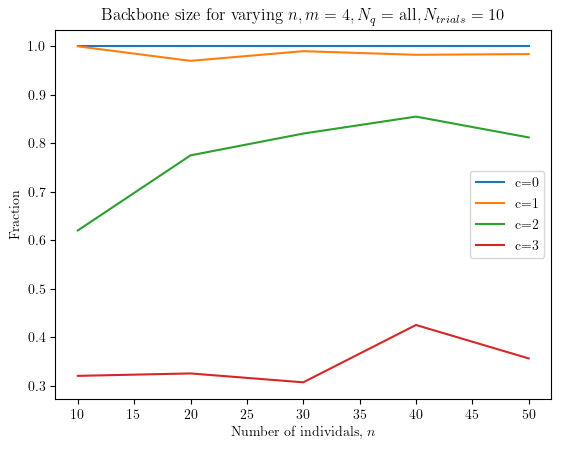

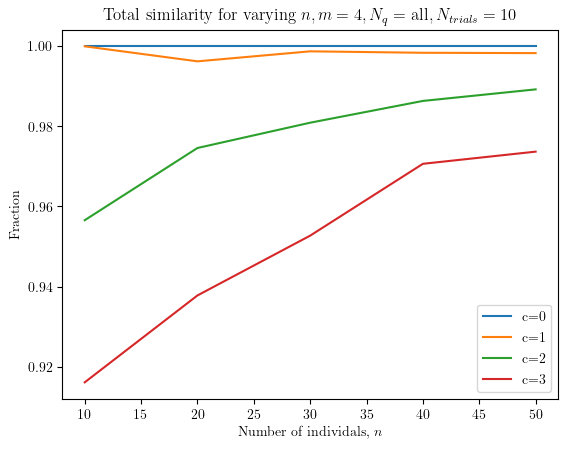

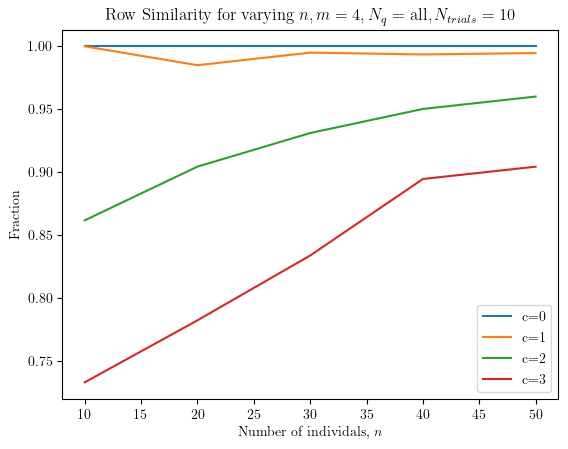

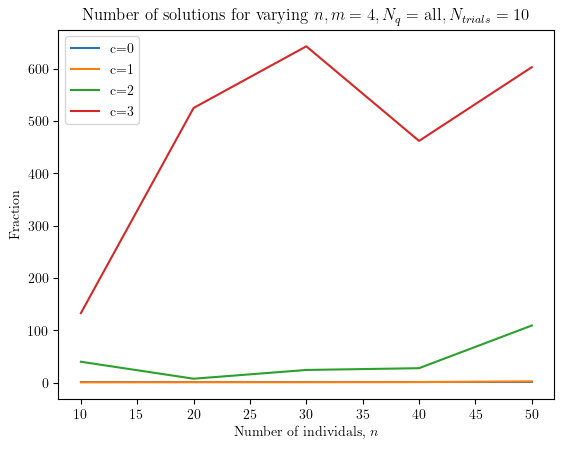

In [21]:
for feature in ['backbone_size', 'tot_avg', 'row_avg', 'N_sols_actual']:    
    heading_dict = {'backbone_size': 'Backbone size', 'tot_avg': 'Total similarity',
                    'row_avg': "Row Similarity", 'N_sols_actual': "Number of solutions"}
    
    data_use = data_n
    
    x0 = data_use[0].keys()
    x1 = data_use[1].keys()
    x2 = data_use[2].keys()
    x3 = data_use[3].keys()
    y0 = [data_use[0][i][feature] for i in x0]
    y1 = [data_use[1][i][feature] for i in x1]
    y2 = [data_use[2][i][feature] for i in x2]
    y3 = [data_use[3][i][feature] for i in x3]
    # if feature == 'tot_avg':
    #     plt.axhline(y = 0.854, color = 'r', linestyle = '-', label = 'random similarity')
    # if feature == 'row_avg':
    #     plt.axhline(y = 0.47, color = 'r', linestyle = '-', label = 'random similarity')
    # x, y = zip(*sorted(zip(x, y)))

    plt.plot(x0, y0, label = 'c=0')
    plt.plot(x1, y1, label = 'c=1')
    # plt.axhline(y1 = 95, color = 'r', linestyle = '-', label = '95\%')
    plt.plot(x2, y2, label = 'c=2')
    plt.plot(x3, y3, label = 'c=3')
    plt.xlabel('Number of individals, $n$')
    plt.ylabel('Fraction')
    # plt.xscale('log')
    # plt.yscale('log')
    plt.title(f'{heading_dict[feature]} for varying $n, m=4, N_q=$ all$, N_{{trials}} =10$')
    # plt.title(f"$c$")
    # plt.ylim([0,105])
    plt.legend()
    plt.savefig(f'initial_plots/{feature}_m_4_n_all_N_t_10_again.pdf') 
    plt.show()

In [243]:
def get_counts_seed(db,quers,noise,quer_noise_dict):
    """Returns noisy count of query, noise is uniform random integer over -noise to noise (inclusive). 
    Will perturb negative counts to 0."""
    out_dict = defaultdict(int)
    for query in quers:
        out_dict[tuple(query)] = max(len(db.query(quer2string(query))) + quer2noise(query,quer_noise_dict,noise),0)
        # print(np.random.randint(-noise,noise+1))
    return out_dict

def quer2noise(query,quer_noise_dict,noise):
    """ generates noise from discrete-RV: U({-noise,noise})
    using the seed in the query dict"""
    # print(query)
    np.random.seed(quer_noise_dict[query])
    return np.random.randint(-noise,noise+1)

In [310]:
def get_results_quer_comp(c,n,m,N_q,N_q_all,N_sols):
    """Compares query types when using a small number of attributes first, 
    large number of attributes first, or random number of attributes, 
    ensures that same queries get the same noise"""

    noise = c
    db = gen_bin_data_set(n,m)
    quers = gen_queries_comp(m)
    # print(quers)
    quer_rand = sample(quers,min(N_q,len(quers)))
    # sorted_quers = sorted([tuple(x) for x in quers],key=binatodeci)
    quer_small = quers[0:min(N_q,len(quers))]
    quer_large = quers[::-1][0:min(N_q,len(quers))]
    
    #ensures that same queries get same noise by keeping a query seed dict
    #which assigns a seed to each query, noise is then generated by setting the seed.
    quer_seed_dict = query_seed_dict(m)
    
    quer_dict_rand = get_counts_seed(db,quer_rand,noise,quer_seed_dict)
    quer_dict_small = get_counts_seed(db,quer_small,noise,quer_seed_dict)
    quer_dict_large = get_counts_seed(db,quer_large,noise,quer_seed_dict)
    
    

    db_tup = sorted([tuple(x) for x in list(db.to_numpy())],key=binatodeci)
    
    titles = {'quer_dict_rand': 'rand','quer_dict_small': 'small','quer_dict_large': 'large'}
    return_dict = defaultdict()
    
    for quer_dict, name in zip([quer_dict_rand,quer_dict_small,quer_dict_large],['rand','small','large']):
        sols_all = gen_sols(n,m,quer_dict,noise,N_sols)
        sols = np.array(sols_all[0], dtype=int) 
        time = sols_all[1] 

        backbone_size = 0
        if len(sols) < N_sols:
            fixed_sols = check_fixed_sols(sols)
            backbone_size = len(fixed_sols)/n

        row_sims = []
        tot_sims = []

        for sol in sols:
            sol_tup = [tuple(x) for x in sol]
            sol_tup, common = sol_tup[:], [ e for e in db_tup if e in sol_tup and (sol_tup.pop(sol_tup.index(e)) or True)]
            tot_sims.append(ass_ILP(db_tup,sol_tup))
            row_sims.append(len(common)/n)

        returns = {'backbone_size': backbone_size, 'tot_avg': np.mean(tot_sims), 'tot_min': np.min(tot_sims),
                  'row_avg': np.mean(row_sims), 'row_min': np.min(row_sims), 'solve_time': time, 'N_sols_actual': len(sols)}
        
        return_dict[name] = returns
    
    return return_dict

In [75]:
c=1
n=30
m=5
N_q=75
N_q_all = 242
N_sols = 1000

get_results_quer_comp(c,n,m,N_q,N_q_all,N_sols)

defaultdict(None,
            {'rand': {'backbone_size': 0.6333333333333333,
              'tot_avg': 0.9712380952380952,
              'tot_min': 0.92,
              'row_avg': 0.8920634920634922,
              'row_min': 0.7333333333333333,
              'solve_time': 0.18016600608825684,
              'N_sols_actual': 105},
             'small': {'backbone_size': 0,
              'tot_avg': 0.9127066666666666,
              'tot_min': 0.84,
              'row_avg': 0.5737333333333333,
              'row_min': 0.2,
              'solve_time': 0.22067999839782715,
              'N_sols_actual': 1000},
             'large': {'backbone_size': 0,
              'tot_avg': 0.9420266666666667,
              'tot_min': 0.9133333333333333,
              'row_avg': 0.7878666666666668,
              'row_min': 0.6333333333333333,
              'solve_time': 13.058012962341309,
              'N_sols_actual': 1000}})

In [309]:
def gen_queries_comp(m):
    """Generates all possible queries of m binary attributes, 
    takes a sample of size n_queries from the set"""
        
    queries = []
    for i in range(1,m+1):
        
        combs = itertools.combinations(range(m),i)
        for comb in combs:
            for choice in gen_powerset(i):
                quer = []
                quer.append(comb)
                quer.append(choice)
                queries.append(tuple(quer))
                
    return queries

In [130]:
def produce_avgs_over_N_q_quer_comp_rand_small_large(n,m,c_range,N_q_range,N_trials,N_sols):
    """ compares query types for using random number attributes, small
    number of attributes first, large number of attributes first"""
    
    N_q_all = 300
    all_results = defaultdict()
    for c in c_range:
        print(c)
        results = defaultdict(lambda: defaultdict())
        for N_q in N_q_range[c]:
            print(N_q)
            temp_rand = []
            temp_small = []
            temp_large = []
            for trial in range(N_trials):
                results_temp = get_results_quer_comp(c,n,m,N_q,N_q_all,N_sols)
                temp_rand.append(results_temp['rand'])
                temp_small.append(results_temp['small'])
                temp_large.append(results_temp['large'])
            df_rand = pd.DataFrame(temp_rand)
            results[N_q]['rand'] = dict(df_rand.mean()) 
            df_small = pd.DataFrame(temp_small)
            results[N_q]['small'] = dict(df_small.mean()) 
            df_large = pd.DataFrame(temp_large)
            results[N_q]['large'] = dict(df_large.mean()) 
        all_results[c] = results
    return all_results

In [86]:
N_q_range = {
            1: np.linspace(75,242,10, dtype = 'int'),
            # 1: np.linspace(40,242,20, dtype = 'int'),
            # 2: np.linspace(100,242,15, dtype = 'int'),
            # 3: np.linspace(170,242,6, dtype = 'int')
            }

data = produce_avgs_over_N_q_quer_comp_rand_small_large(30,5,[1],N_q_range,10,1000)

1
75
93
112
130
149
167
186
204
223
242


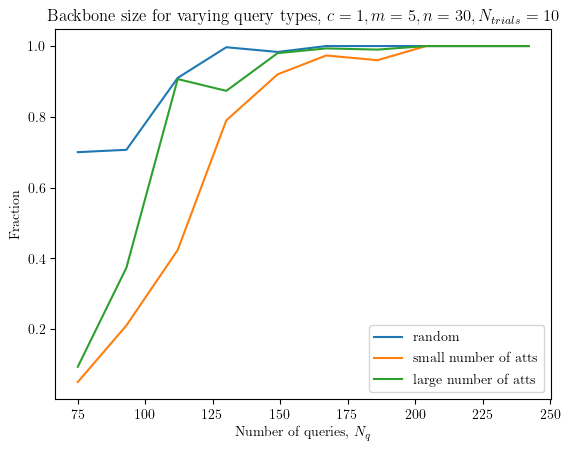

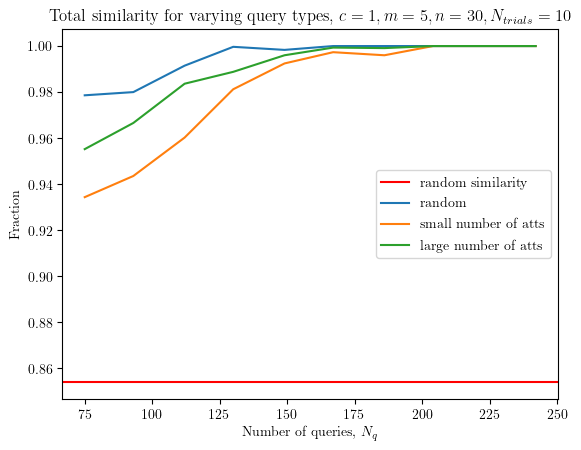

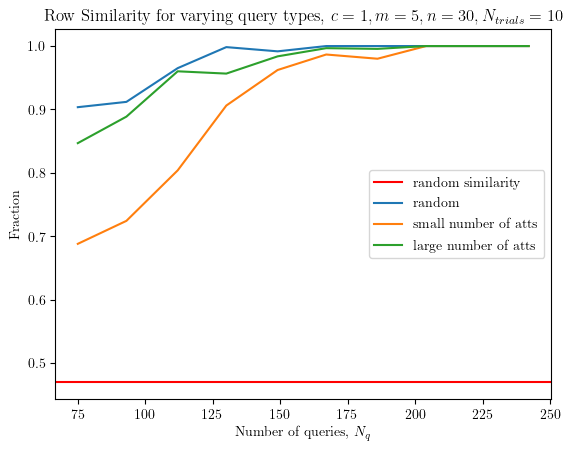

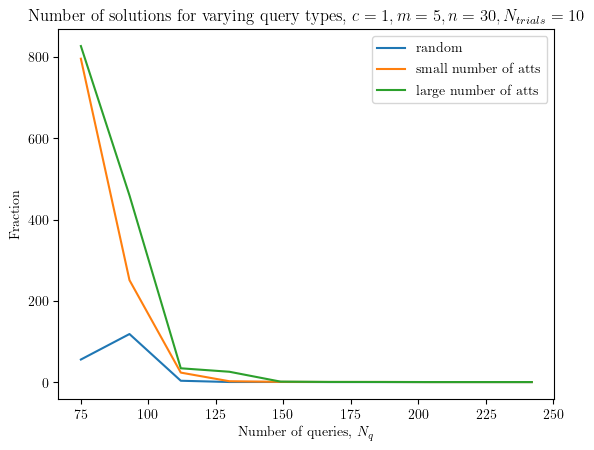

In [96]:
for feature in ['backbone_size', 'tot_avg', 'row_avg', 'N_sols_actual']:    
    heading_dict = {'backbone_size': 'Backbone size', 'tot_avg': 'Total similarity',
                    'row_avg': "Row Similarity", 'N_sols_actual': "Number of solutions"}
    
    for c in data.keys():
    
        # x_rand = data[c].keys()
        # # print(x_rand)
        # x_small = data[c].keys()
        # x_large = data[c].keys()
        x_rand = np.linspace(75,242,10, dtype = 'int')
        x_small = np.linspace(75,242,10, dtype = 'int')
        x_large = np.linspace(75,242,10, dtype = 'int')
        y_rand = [data[c][i]['rand'][feature] for i in x_rand]
        y_small = [data[c][i]['small'][feature] for i in x_small]
        y_large = [data[c][i]['large'][feature] for i in x_large]

        if feature == 'tot_avg':
            plt.axhline(y = 0.854, color = 'r', linestyle = '-', label = 'random similarity')
            #random similarity calculated by applying optimal assignment ILP to two uniformly 
            #randomly generated (iid U({0,1}) RVs) databases, averaged over ~500 times
        if feature == 'row_avg':
            plt.axhline(y = 0.47, color = 'r', linestyle = '-', label = 'random similarity')
            #same but for row similarity
            

        plt.plot(x_rand, y_rand, label = 'random')
        plt.plot(x_small, y_small, label = 'small number of atts')
        # plt.axhline(y1 = 95, color = 'r', linestyle = '-', label = '95\%')
        plt.plot(x_large, y_large, label = 'large number of atts')
        plt.xlabel('Number of queries, $N_q$')
        plt.ylabel('Fraction')
        # plt.xscale('log')
        # plt.yscale('log')
        plt.title(f'{heading_dict[feature]} for varying query types, $c = {c}, m=5, n=30, N_{{trials}} =10$')
        # plt.title(f"$c$")
        # plt.ylim([0,105])
        plt.legend()
        # plt.savefig(f'N_q_n_30_n_5_c_0_1_2_3/quer_comp_{feature}_c_{c}_m_5_n_30_N_t_30.pdf') 
        plt.show()

In [131]:
def gen_powerset_test(k):
    """ generates a powerset of k elements """
    out = []
    for i in itertools.product([0,1],repeat=k):
        out.append(i)
    return out

def flipped_choice(choice):
    """ returns the compliment of a query"""
    return tuple([abs(1-x) for x in choice])

def gen_queries_compliment(m,n_queries):
    """Generates all possible queries of m binary attributes, 
    takes a sample of size n_queries from the set"""
        
    queries = []
    for i in range(1,m+1):
        
        combs = itertools.combinations(range(m),i)
        for comb in combs:
            used = []
            for choice in gen_powerset(i):
                if choice not in used:
                    quer = []
                    used.append(flipped_choice(choice))
                    quer.append(comb)
                    quer.append(choice)
                    queries.append(tuple(quer))
            
            
    sampled = sample(queries,min(int(n_queries/2),len(queries)))
    sample_with_compliment = list(sampled)
    for quer in sampled:
        sample_with_compliment.append((quer[0],flipped_choice(quer[1])))  
    
    return sample_with_compliment

In [237]:
def query_seed_dict(m):
    """ assigns a seed to every possible query based on the m attributes"""
    quer_dict = defaultdict()
    queries = gen_queries_uniform_complete(m,2000)
    for query in queries:
        quer_dict[query] = int(np.random.uniform()*100000)
    # print(quer_dict)
    return quer_dict

In [233]:
compare_backbone_quer_compliment(1,30,2,6,1)

defaultdict(None, {((0, 1), (0, 0)): 42947, ((1,), (1,)): 80467, ((1,), (0,)): 79460, ((0, 1), (0, 1)): 89082, ((0, 1), (1, 1)): 64289, ((0,), (1,)): 2469, ((0,), (0,)): 98751, ((0, 1), (1, 0)): 29644})
((0, 1), (1, 0))
((1,), (1,))
((0, 1), (1, 1))
((0,), (1,))
((1,), (0,))
((0, 1), (0, 1))
((0,), (0,))
((1,), (0,))
((0, 1), (0, 0))
((0,), (1,))
((1,), (1,))
((0, 1), (1, 1))
defaultdict(<class 'int'>, {((0, 1), (1, 0)): 5, ((1,), (1,)): 16, ((0, 1), (1, 1)): 8, ((0,), (1,)): 14, ((1,), (0,)): 12, ((0, 1), (0, 1)): 8})
defaultdict(<class 'int'>, {((0,), (0,)): 17, ((1,), (0,)): 12, ((0, 1), (0, 0)): 7, ((0,), (1,)): 14, ((1,), (1,)): 16, ((0, 1), (1, 1)): 8})


In [247]:
def compare_backbone_quer_compliment(c,n,m,N_q,N_sols):
    """compares random query with and without forcing compliment to 
    be included, based on size of backbone"""
    if N_q%2 == 1:
        N_q+=1
    noise = c
    db = gen_bin_data_set(n,m)
    quers_normal = gen_queries_uniform_complete(m,N_q)
    quers_compliment = gen_queries_compliment(m,N_q)

    #ensures that same queries get same noise by keeping a query seed dict
    #which assigns a seed to each query, noise is then generated by setting the seed.
    quer_seed_dict = query_seed_dict(m)
    quer_dict_normal = get_counts_seed(db,quers_normal,noise,quer_seed_dict)
    quer_dict_compliment = get_counts_seed(db,quers_compliment,noise,quer_seed_dict)
    
    # print(quer_dict_normal)
    # print(quer_dict_compliment)
    db_tup = sorted([tuple(x) for x in list(db.to_numpy())],key=binatodeci)
    titles = {'quer_dict_normal': 'rand','quer_dict_compliment': 'comp'}
    return_dict = defaultdict()
    
    for quer_dict, name in zip([quer_dict_normal,quer_dict_compliment],['rand','comp']):
        sols = np.array(gen_sols(n,m,quer_dict,noise,N_sols)[0], dtype = int)
        backbone_size = 0
        if len(sols) < N_sols:
            fixed_sols = check_fixed_sols(sols)
            backbone_size = len(fixed_sols)/n
        return_dict[name] = backbone_size
    return return_dict
            

def get_results_quer_comp_compliment(c,n,m,N_q,N_sols):
    """compares random query type with and without enforcing compliment
    based on all the tests"""
    
    ##### right now each N_q gets its own database, would be interesting to see how the 
    ##### similarity scores change over N_q for the database held constant, and 
    ##### more queries are added, rather than reselected
    
    if N_q%2 == 1:
        N_q+=1
    noise = c
    db = gen_bin_data_set(n,m)
    
    quers_normal = gen_queries_uniform_complete(m,N_q)
    quers_compliment = gen_queries_compliment(m,N_q)

    #ensures that same queries get same noise by keeping a query seed dict
    #which assigns a seed to each query, noise is then generated by setting the seed.
    quer_seed_dict = query_seed_dict(m)
    quer_dict_normal = get_counts_seed(db,quers_normal,noise,quer_seed_dict)
    quer_dict_compliment = get_counts_seed(db,quers_compliment,noise,quer_seed_dict)

    db_tup = sorted([tuple(x) for x in list(db.to_numpy())],key=binatodeci)
    
    titles = {'quer_dict_normal': 'rand','quer_dict_compliment': 'comp'}
    return_dict = defaultdict()
    
    for quer_dict, name in zip([quer_dict_normal,quer_dict_compliment],['rand','comp']):
        sols_all = gen_sols(n,m,quer_dict,noise,N_sols)
        sols = np.array(sols_all[0], dtype=int) 
        time = sols_all[1] 

        backbone_size = 0
        if len(sols) < N_sols:
            fixed_sols = check_fixed_sols(sols)
            backbone_size = len(fixed_sols)/n

        row_sims = []
        tot_sims = []

        for sol in sols:
            sol_tup = [tuple(x) for x in sol]
            sol_tup, common = sol_tup[:], [ e for e in db_tup if e in sol_tup and (sol_tup.pop(sol_tup.index(e)) or True)]
            tot_sims.append(ass_ILP(db_tup,sol_tup))
            row_sims.append(len(common)/n)

        returns = {'backbone_size': backbone_size, 'tot_avg': np.mean(tot_sims), 'tot_min': np.min(tot_sims),
                  'row_avg': np.mean(row_sims), 'row_min': np.min(row_sims), 'solve_time': time, 'N_sols_actual': len(sols)}
        
        return_dict[name] = returns
    
    return return_dict

def produce_avgs_over_N_q_quer_comp_rand_compliment(n,m,c_range,N_q_range,N_trials,N_sols):
    """ compares query types for using random number attributes, with
    and without enforcing compliment"""
    
    all_results = defaultdict()
    for c in c_range:
        print(c)
        results = defaultdict(lambda: defaultdict())
        for N_q in N_q_range[c]:
            print(N_q)
            temp_rand = []
            temp_small = []
            for trial in range(N_trials):
                results_temp = get_results_quer_comp_compliment(c,n,m,N_q,N_sols)
                temp_rand.append(results_temp['rand'])
                temp_small.append(results_temp['comp'])
            df_rand = pd.DataFrame(temp_rand)
            results[N_q]['rand'] = dict(df_rand.mean()) 
            df_small = pd.DataFrame(temp_small)
            results[N_q]['comp'] = dict(df_small.mean()) 
        all_results[c] = results
    return all_results

In [240]:
results_norm = []
results_comp = []
c = 3
n = 30
m = 5
N_q = 175
N_sols = 1000
N_trials = 1
for i in range(N_trials):
    results = compare_backbone_quer_compliment(c,n,m,N_q,N_sols)
    results_norm.append(results['rand'])
    results_comp.append(results['comp'])
print(f"backbone_size normal: {np.mean(results_norm)}")
print(f"backbone_size with compliment: {np.mean(results_comp)}")

backbone_size normal: 0.0
backbone_size with compliment: 0.0


In [242]:
print(np.linspace(122,242,10, dtype = 'int'))

[122 135 148 162 175 188 202 215 228 242]


In [250]:
N_q_range = {
            1: np.linspace(50,200,10, dtype = 'int'),
            # 1: np.linspace(40,242,20, dtype = 'int'),
            # 2: np.linspace(100,242,15, dtype = 'int'),
            # 3: np.linspace(170,242,6, dtype = 'int')
            }

data = produce_avgs_over_N_q_quer_comp_rand_compliment(30,5,[1],N_q_range,10,1000)

1
50
66
83
100
116
133
150
166
183
200


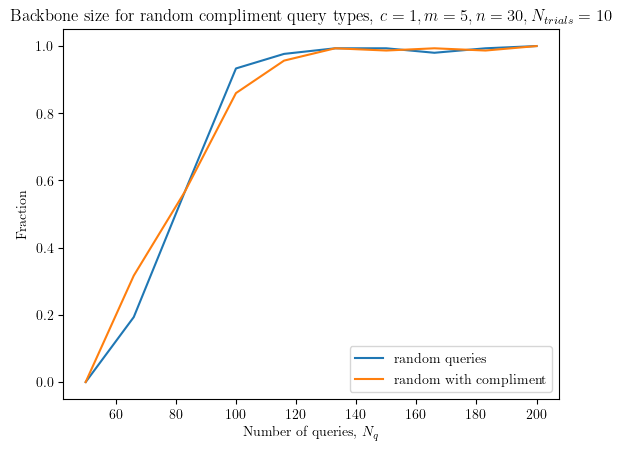

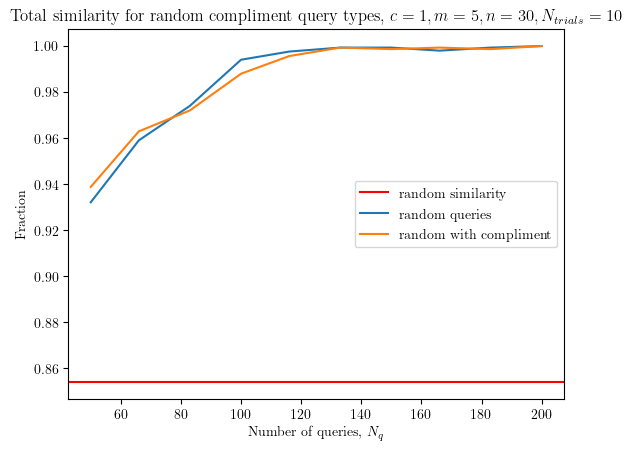

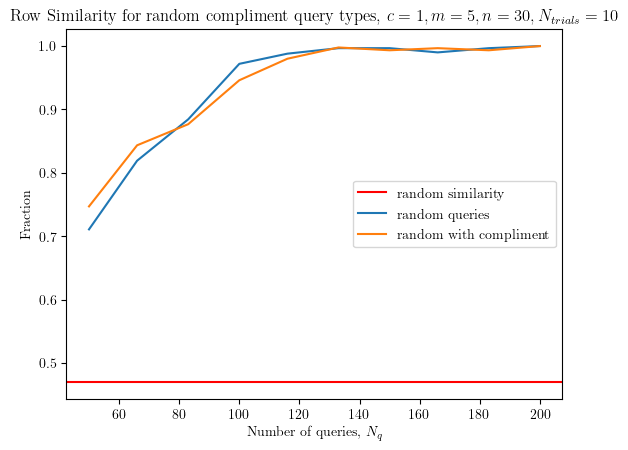

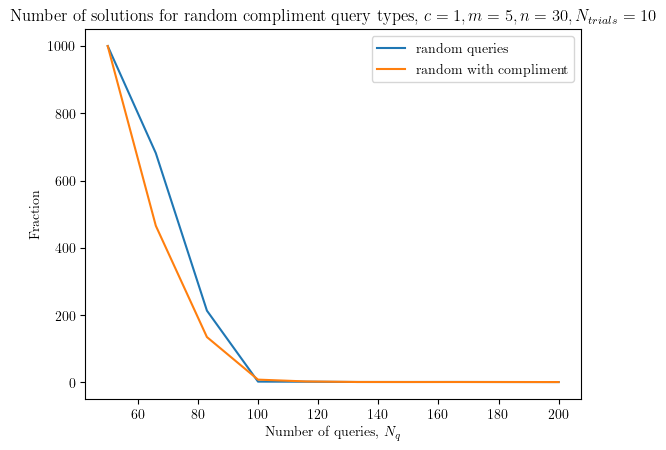

In [251]:
for feature in ['backbone_size', 'tot_avg', 'row_avg', 'N_sols_actual']:    
    heading_dict = {'backbone_size': 'Backbone size', 'tot_avg': 'Total similarity',
                    'row_avg': "Row Similarity", 'N_sols_actual': "Number of solutions"}
    
    for c in data.keys():
    
        x_rand = data[c].keys()
        # print(x_rand)
        x_small = data[c].keys()
        # x_rand = np.linspace(75,242,10, dtype = 'int')
        # x_small = np.linspace(75,242,10, dtype = 'int')
        # x_large = np.linspace(75,242,10, dtype = 'int')
        y_rand = [data[c][i]['rand'][feature] for i in x_rand]
        y_small = [data[c][i]['comp'][feature] for i in x_small]

        if feature == 'tot_avg':
            plt.axhline(y = 0.854, color = 'r', linestyle = '-', label = 'random similarity')
            #random similarity calculated by applying optimal assignment ILP to two uniformly 
            #randomly generated (iid U({0,1}) RVs) databases, averaged over ~500 times
        if feature == 'row_avg':
            plt.axhline(y = 0.47, color = 'r', linestyle = '-', label = 'random similarity')
            #same but for row similarity
            

        plt.plot(x_rand, y_rand, label = 'random queries')
        plt.plot(x_small, y_small, label = 'random with compliment')
        # plt.axhline(y1 = 95, color = 'r', linestyle = '-', label = '95\%')
        plt.xlabel('Number of queries, $N_q$')
        plt.ylabel('Fraction')
        # plt.xscale('log')
        # plt.yscale('log')
        plt.title(f'{heading_dict[feature]} for random compliment query types, $c = {c}, m=5, n=30, N_{{trials}} =10$')
        # plt.title(f"$c$")
        # plt.ylim([0,105])
        plt.legend()
        plt.savefig(f'N_q_n_30_n_5_c_0_1_2_3/quer_comp_compliment_seeds_{feature}_c_{c}_m_5_n_30_N_t_10.pdf') 
        plt.show()

In [208]:
def check(seed):
    np.random.seed(seed)
    return(np.random.uniform())

In [209]:
print(check(2))
print(check(2))

0.43599490214200376
0.43599490214200376


In [313]:
gen_queries_comp(3)

[((0,), (0,)),
 ((0,), (1,)),
 ((1,), (0,)),
 ((1,), (1,)),
 ((2,), (0,)),
 ((2,), (1,)),
 ((0, 1), (0, 0)),
 ((0, 1), (0, 1)),
 ((0, 1), (1, 0)),
 ((0, 1), (1, 1)),
 ((0, 2), (0, 0)),
 ((0, 2), (0, 1)),
 ((0, 2), (1, 0)),
 ((0, 2), (1, 1)),
 ((1, 2), (0, 0)),
 ((1, 2), (0, 1)),
 ((1, 2), (1, 0)),
 ((1, 2), (1, 1)),
 ((0, 1, 2), (0, 0, 0)),
 ((0, 1, 2), (0, 0, 1)),
 ((0, 1, 2), (0, 1, 0)),
 ((0, 1, 2), (0, 1, 1)),
 ((0, 1, 2), (1, 0, 0)),
 ((0, 1, 2), (1, 0, 1)),
 ((0, 1, 2), (1, 1, 0)),
 ((0, 1, 2), (1, 1, 1))]

In [268]:
print(np.random.shuffle(np.array([1,2,3,4,5])))

None


In [311]:
def additive_queries(c,n,m,N_q_range,N_sols):
    """Generates similarity measures over a range of N_q, although
    keeps the database constant over the range, and queries are additive
    in the sense that queries used in earlier 'iterations' are also used in 
    later iterations. iterations represent number of queries asked."""

    noise = c
    db = gen_bin_data_set(n,m)
    
    # might not need to be shuffled, just making sure
    quers = gen_queries_comp(m)
    np.random.shuffle(quers)
    quer_seed_dict = query_seed_dict(m)
    quer_dict_all = get_counts_seed(db,quers,noise,quer_seed_dict)

    db_tup = sorted([tuple(x) for x in list(db.to_numpy())],key=binatodeci)
    return_dict = defaultdict()
    
    for N_q in N_q_range:
        queries = quers[0:N_q]
        quer_dict = dict((k, quer_dict_all[k]) for k in queries)
    
        sols_all = gen_sols(n,m,quer_dict,noise,N_sols)
        sols = np.array(sols_all[0], dtype=int) 
        time = sols_all[1] 

        backbone_size = 0
        if len(sols) < N_sols:
            fixed_sols = check_fixed_sols(sols)
            backbone_size = len(fixed_sols)/n

        row_sims = []
        tot_sims = []

        for sol in sols:
            sol_tup = [tuple(x) for x in sol]
            sol_tup, common = sol_tup[:], [ e for e in db_tup if e in sol_tup and (sol_tup.pop(sol_tup.index(e)) or True)]
            tot_sims.append(ass_ILP(db_tup,sol_tup))
            row_sims.append(len(common)/n)

        returns = {'backbone_size': backbone_size, 'tot_avg': np.mean(tot_sims), 'tot_min': np.min(tot_sims),
                  'row_avg': np.mean(row_sims), 'row_min': np.min(row_sims), 'solve_time': time, 'N_sols_actual': len(sols)}
        
        return_dict[int(N_q)] = returns
    
    return return_dict

In [302]:
data_Nq = []
for i in range(2):
    data_Nq.append(additive_queries(1,30,5,np.linspace(50,242,25, dtype = 'int'),1000))

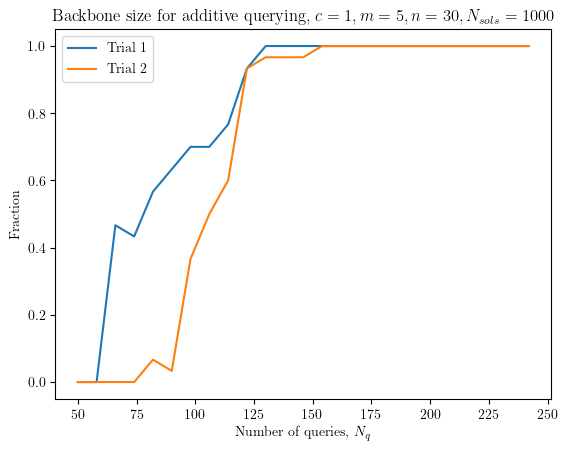

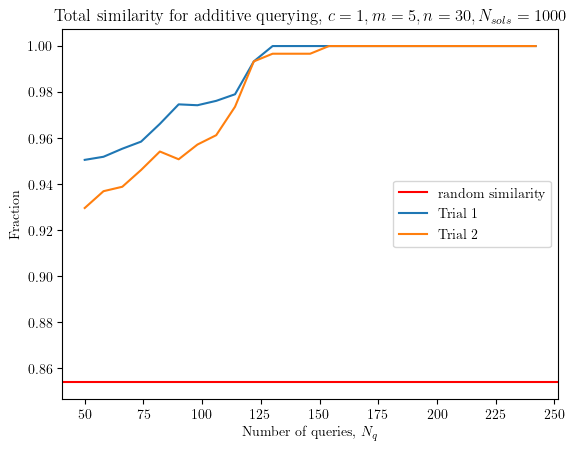

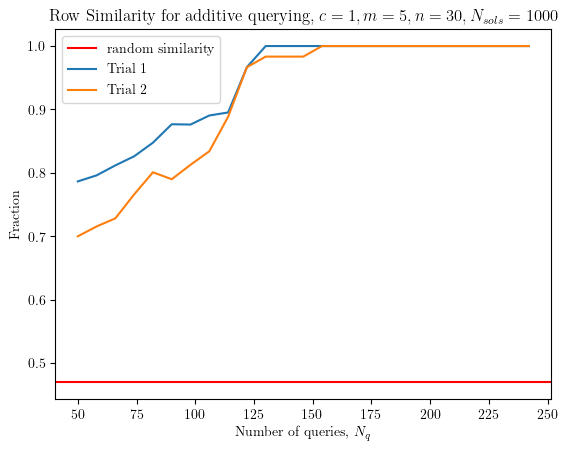

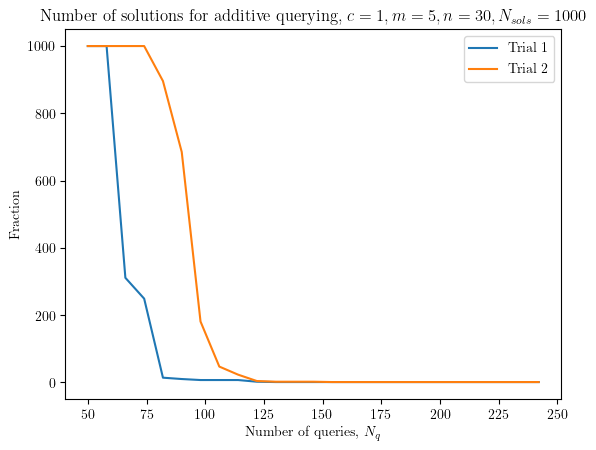

In [303]:
for feature in ['backbone_size', 'tot_avg', 'row_avg', 'N_sols_actual']:    
    heading_dict = {'backbone_size': 'Backbone size', 'tot_avg': 'Total similarity',
                    'row_avg': "Row Similarity", 'N_sols_actual': "Number of solutions"}
    x_0 = data_Nq[0].keys()
    # print(x_rand)
    x_1 = data_Nq[1].keys()
    # x_rand = np.linspace(75,242,10, dtype = 'int')
    # x_small = np.linspace(75,242,10, dtype = 'int')
    # x_large = np.linspace(75,242,10, dtype = 'int')
    y_0 = [data_Nq[0][i][feature] for i in x_0]
    y_1 = [data_Nq[1][i][feature] for i in x_1]

    if feature == 'tot_avg':
        plt.axhline(y = 0.854, color = 'r', linestyle = '-', label = 'random similarity')
        #random similarity calculated by applying optimal assignment ILP to two uniformly 
        #randomly generated (iid U({0,1}) RVs) databases, averaged over ~500 times
    if feature == 'row_avg':
        plt.axhline(y = 0.47, color = 'r', linestyle = '-', label = 'random similarity')
        #same but for row similarity


    plt.plot(x_0, y_0, label = 'Trial 1')
    plt.plot(x_1, y_1, label = 'Trial 2')
    # plt.axhline(y1 = 95, color = 'r', linestyle = '-', label = '95\%')
    plt.xlabel('Number of queries, $N_q$')
    plt.ylabel('Fraction')
    # plt.xscale('log')
    # plt.yscale('log')
    plt.title(f'{heading_dict[feature]} for additive querying, $c = {c}, m=5, n=30,N_{{sols}} = 1000$')
    # plt.title(f"$c$")
    # plt.ylim([0,105])
    plt.legend()
    plt.savefig(f'N_q_n_30_n_5_c_0_1_2_3/additive_queries_{feature}_c_{c}_m_5_n_30_N_t_1.pdf') 
    plt.show()